In [1]:
# import darts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
# from darts.models import ExponentialSmoothing, Prophet, AutoARIMA
#https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv
data = pd.read_csv('../data/train.csv')
print(data.shape)
print(f'unique store count:{data.store.nunique()}')
print(f'unique item count:{data.item.nunique()}')
print(f'time series from {data.date.min()} to {data.date.max()}')
data.head()

(913000, 4)
unique store count:10
unique item count:50
time series from 2013-01-01 to 2017-12-31


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### Hierarchial Time Series data preparation

In [2]:
data['store_item'] = data[['store', 'item']].apply(lambda x: f"store_{x['store']}_item_{x['item']}", axis = 1)
df_store_item_level = data.pivot(index='date',columns = 'store_item',values='sales')
df_store_level = data.groupby(['date', 'store']).sum().reset_index().pivot(index = 'date',columns = 'store', values= 'sales')
df_store_level.columns = [f"store_{i}" for i in df_store_level.columns]
df_item_level = data.groupby(['date', 'item']).sum().reset_index().pivot(index = 'date',columns = 'item', values= 'sales')
df_item_level.columns = [f"item_{i}" for i in df_item_level.columns]
df_total = data.groupby('date')['sales'].sum().to_frame().rename(columns={'sales':'Total'})

#merge all the hierarchies
hierarchy_df = df_store_item_level.join(df_store_level).join(df_item_level).join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
print(f'Total Hierarchy count:{len(hierarchy_df.columns)}')
print(f'total series length: {len(hierarchy_df)}')
hierarchy_df.head(3)

Total Hierarchy count:561
total series length: 1826


/tmp/ipykernel_26644/1920834405.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_store_level = data.groupby(['date', 'store']).sum().reset_index().pivot(index = 'date',columns = 'store', values= 'sales')
/tmp/ipykernel_26644/1920834405.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_item_level = data.groupby(['date', 'item']).sum().reset_index().pivot(index = 'date',columns = 'item', values= 'sales')


,store_10_item_1,store_10_item_10,store_10_item_11,store_10_item_12,store_10_item_13,store_10_item_14,store_10_item_15,store_10_item_16,store_10_item_17,store_10_item_18,...,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,Total
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,14,45,49,41,46,30,51,20,20,45,...,195,253,154,396,319,116,277,159,330,13696
2013-01-02,14,50,47,36,57,48,59,18,17,48,...,215,255,165,393,316,118,281,159,384,13678
2013-01-03,16,53,60,39,36,45,49,10,25,50,...,215,306,170,459,325,104,280,187,356,14488


In [3]:
#Hierarchical structure for time series data
hierarchy = dict()
stores = list(data['store'].unique())
stores = [f'store_{i}'for i in stores]
items = list(data['item'].unique())
items = [f'item_{i}'for i in items]
total = ['Total']

for store in stores:
    hierarchy[store] = total

for item in items:
    hierarchy[item] = total  

from itertools import product
for store,item in product(stores,items):
    hierarchy[f'{store}_{item}'] = [item] +  [store]

hierarchy    

{'store_1': ['Total'],
 'store_2': ['Total'],
 'store_3': ['Total'],
 'store_4': ['Total'],
 'store_5': ['Total'],
 'store_6': ['Total'],
 'store_7': ['Total'],
 'store_8': ['Total'],
 'store_9': ['Total'],
 'store_10': ['Total'],
 'item_1': ['Total'],
 'item_2': ['Total'],
 'item_3': ['Total'],
 'item_4': ['Total'],
 'item_5': ['Total'],
 'item_6': ['Total'],
 'item_7': ['Total'],
 'item_8': ['Total'],
 'item_9': ['Total'],
 'item_10': ['Total'],
 'item_11': ['Total'],
 'item_12': ['Total'],
 'item_13': ['Total'],
 'item_14': ['Total'],
 'item_15': ['Total'],
 'item_16': ['Total'],
 'item_17': ['Total'],
 'item_18': ['Total'],
 'item_19': ['Total'],
 'item_20': ['Total'],
 'item_21': ['Total'],
 'item_22': ['Total'],
 'item_23': ['Total'],
 'item_24': ['Total'],
 'item_25': ['Total'],
 'item_26': ['Total'],
 'item_27': ['Total'],
 'item_28': ['Total'],
 'item_29': ['Total'],
 'item_30': ['Total'],
 'item_31': ['Total'],
 'item_32': ['Total'],
 'item_33': ['Total'],
 'item_34': ['Total

### Covert to ndarray for Dart

In [4]:
df_series = TimeSeries.from_dataframe(hierarchy_df)
df_series = df_series.with_hierarchy(hierarchy)
df_series

<TimeSeries (DataArray) (date: 1826, component: 561, sample: 1)>
array([[[1.4000e+01],
        [4.5000e+01],
        [4.9000e+01],
        ...,
        [1.5900e+02],
        [3.3000e+02],
        [1.3696e+04]],

       [[1.4000e+01],
        [5.0000e+01],
        [4.7000e+01],
        ...,
        [1.5900e+02],
        [3.8400e+02],
        [1.3678e+04]],

       [[1.6000e+01],
        [5.3000e+01],
        [6.0000e+01],
        ...,
...
        ...,
        [2.3700e+02],
        [5.9600e+02],
        [2.3535e+04]],

       [[2.6000e+01],
        [8.6000e+01],
        [7.7000e+01],
        ...,
        [3.0300e+02],
        [6.1200e+02],
        [2.4988e+04]],

       [[2.7000e+01],
        [6.7000e+01],
        [9.8000e+01],
        ...,
        [2.8500e+02],
        [6.2600e+02],
        [2.6420e+04]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 'store_10_item_1' ... 'Total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          {'store_1': ['Total'], 'store_2': ['Total'], 'store_3...

### Benchmark Model for Hierarchical Time Series Forecasting

In [7]:
import torch
from darts.models.forecasting.linear_regression_model import LinearRegressionModel

#splitting the data into train and test
train, test = df_series[:-30],df_series[-30:]

#model fitting and prediction
model = LinearRegressionModel(lags = 30)
model.fit(train)
prediction = model.predict(len(test))
prediction

<TimeSeries (DataArray) (date: 30, component: 561, sample: 1)>
array([[[2.94887017e+01],
        [8.44286198e+01],
        [6.69687308e+01],
        ...,
        [2.89306463e+02],
        [6.75661872e+02],
        [2.65279210e+04]],

       [[2.08092918e+01],
        [8.21404179e+01],
        [6.74788444e+01],
        ...,
        [3.08552414e+02],
        [7.52612453e+02],
        [2.83882757e+04]],

       [[1.18444508e+01],
        [4.91528838e+01],
        [4.26586115e+01],
        ...,
...
        ...,
        [1.99872851e+02],
        [4.71320762e+02],
        [1.89964445e+04]],

       [[2.46731378e+01],
        [7.38388337e+01],
        [5.17749186e+01],
        ...,
        [2.41579717e+02],
        [5.36713908e+02],
        [2.10028011e+04]],

       [[2.17384701e+01],
        [6.64159840e+01],
        [7.05890173e+01],
        ...,
        [2.58498940e+02],
        [5.95561706e+02],
        [2.28672778e+04]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-12-02 2017-12-03 ... 2017-12-31
  * component  (component) object 'store_10_item_1' ... 'Total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          {'store_1': ['Total'], 'store_2': ['Total'], 'store_3...

### Performance

In [21]:
from darts.metrics import mae,mape,r2_score,mse
store_item = [f'{store}_{item}' for store,item in product(stores,items)]
def calculate_mae_entite(pred):
    def calculate_mae_subset(val,subsets):
        mae_subsets = mape([test[subset] for subset in subsets],[pred[subset] for subset in subsets], inter_reduction=np.mean)
        return mae_subsets
    print(f'MAPE at store subsets: {np.round(calculate_mae_subset(test,stores),3)}')
    print(f'MAPE at item subsets: {np.round(calculate_mae_subset(test,items),3)}')
    print(f'MAPE at store-item subsets: {np.round(calculate_mae_subset(test,store_item),3)}')
    print(f"MAPE at total: {np.round(calculate_mae_subset(test,subsets=['Total']),3)}")

calculate_mae_entite(prediction) 

MAPE at store subsets: 7.121
MAPE at item subsets: 8.597
MAPE at store-item subsets: 20.048
MAPE at total: 6.796


### Reconciliation

Raw forecasted data(Before Reconcialiation)

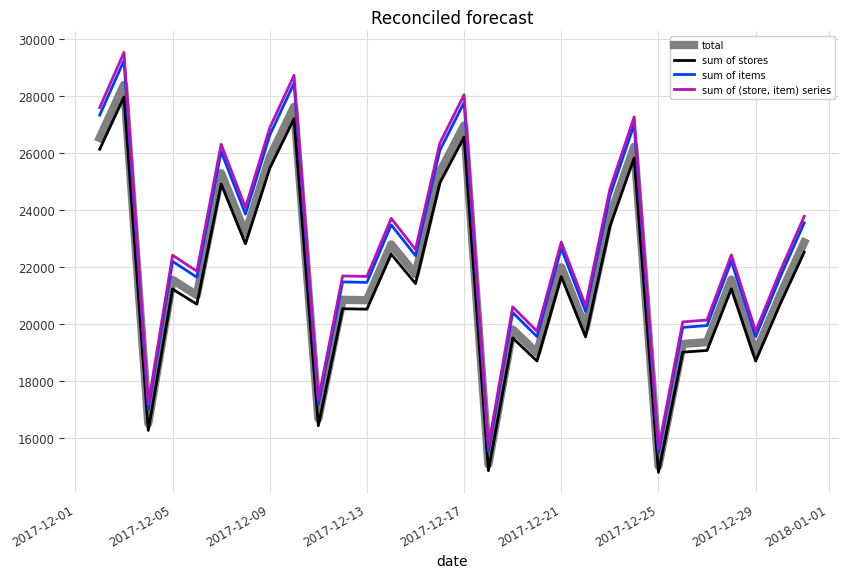

In [11]:
store_item = [f'{store}_{item}' for store,item in product(stores,items)]
from matplotlib import pyplot as plt
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 6))

    pred_series["Total"].plot(label="total", lw=6, alpha=0.3, color="grey")
    sum([pred_series[r] for r in stores]).plot(label="sum of stores")
    sum([pred_series[i] for i in items]).plot(label="sum of items")
    sum([pred_series[t] for t in store_item]).plot(
        label="sum of (store, item) series"
    )
    plt.title("Reconciled forecast")

    legend = plt.legend(loc="best", frameon=1, framealpha=1, facecolor="white", fontsize=7)
    frame = legend.get_frame()
    frame.set_facecolor("white")
plot_forecast_sums(prediction)

After Reconcialiation

MinTReconciliator
MAPE at store subsets: 7.121
MAPE at item subsets: 8.597
MAPE at store-item subsets: 20.048
MAPE at total: 6.796
TopDownReconciliator
MAPE at store subsets: 6.976
MAPE at item subsets: 7.743
MAPE at store-item subsets: 15.501
MAPE at total: 6.796
BottomUpReconciliator
MAPE at store subsets: 7.121
MAPE at item subsets: 8.597
MAPE at store-item subsets: 20.048
MAPE at total: 6.796


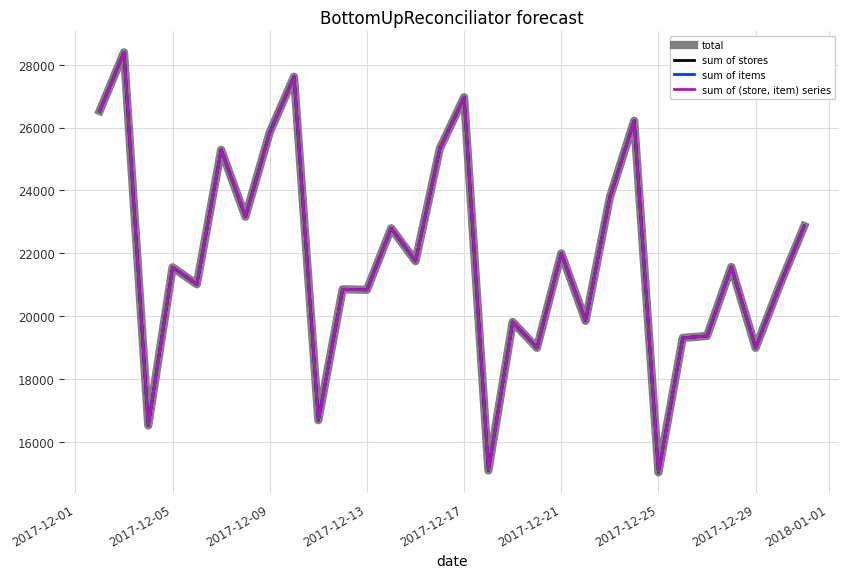

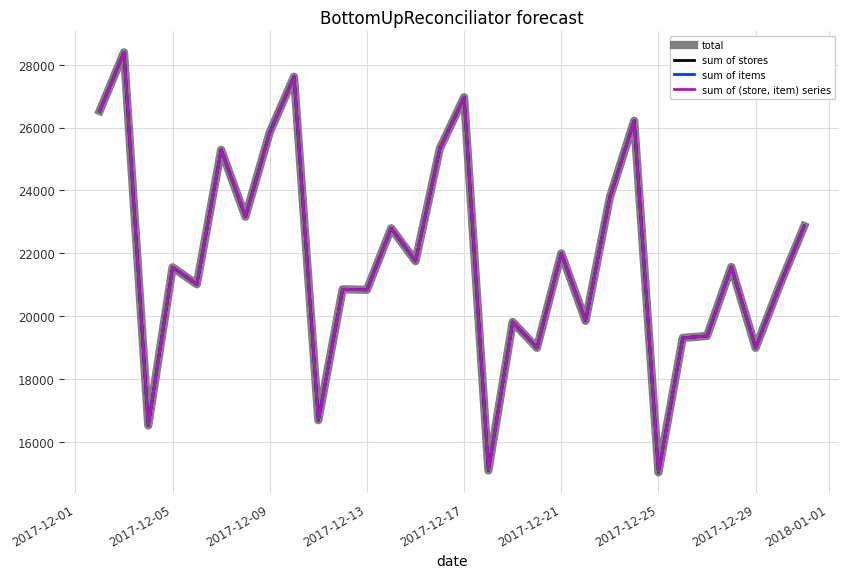

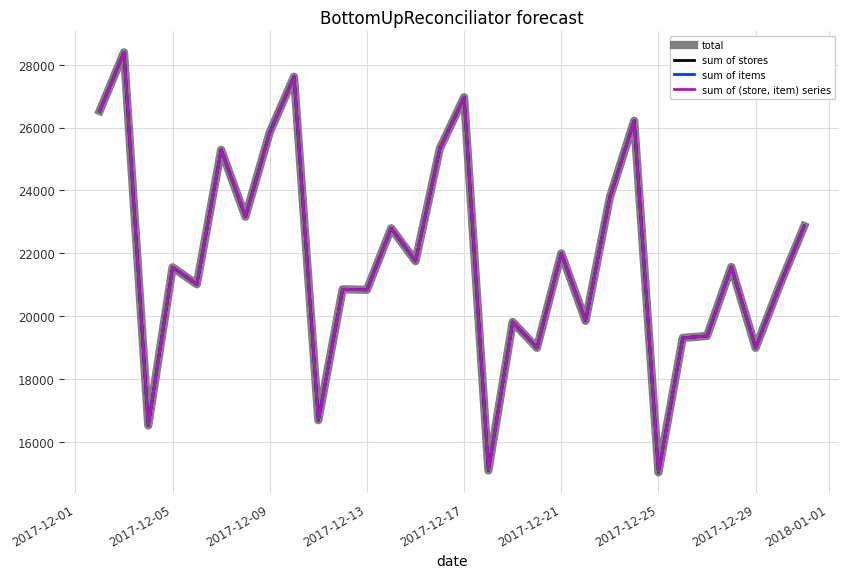

In [22]:
from darts.dataprocessing.transformers import MinTReconciliator,TopDownReconciliator,BottomUpReconciliator

#MinTReconciliator
from termcolor import colored
print(colored("MinTReconciliator","blue"))
min_t = MinTReconciliator("wls_val")
min_t.fit(train.with_hierarchy(hierarchy=hierarchy))
reconciled_predictions = min_t.transform(prediction.with_hierarchy(hierarchy=hierarchy))
plot_forecast_sums(reconciled_predictions)
calculate_mae_entite(reconciled_predictions)

#TopDownReconciliator
print(colored("TopDownReconciliator","blue"))
top_down = TopDownReconciliator()
top_down.fit(train.with_hierarchy(hierarchy=hierarchy))
reconciled_predictions = top_down.transform(prediction.with_hierarchy(hierarchy=hierarchy))
plot_forecast_sums(reconciled_predictions)
calculate_mae_entite(reconciled_predictions)

#BottomUpReconciliator
print(colored("BottomUpReconciliator","blue"))
bottom_up = BottomUpReconciliator()
reconciled_predictions = bottom_up.transform(prediction.with_hierarchy(hierarchy=hierarchy))
plot_forecast_sums(reconciled_predictions)
calculate_mae_entite(reconciled_predictions)